In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np



db = mysql.connector.connect(host = "127.0.0.1",
                             username = "root",
                             password = "vaibhav@#1234",
                             database = "ecommerce")

cur = db.cursor()

#   List all unique cities where customers are located .                 

In [94]:
query = """select distinct customer_city from customers"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017

In [4]:
# query = """select count(order_id) from orders where year (order_purchase_timestamp) = 2017 """
query = """SELECT count(order_id) FROM ecommerce.orders where order_purchase_timestamp = 2017"""
cur.execute(query)

data = cur.fetchall()
data

"total orders placed in 2017 are ",data[0][0]

('total orders placed in 2017 are ', 90202)

# Find the total sales per category

In [42]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category """

cur.execute(query)

data = cur.fetchall()


df = pd.DataFrame(data,columns = ["category","sales"])
df

,category,sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,FASHION BAGS AND ACCESSORIES,1745266.24
4,BED TABLE BATH,13700429.37
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


# Calculate the percentage of orders that were paid in installments.


In [57]:
query = """select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from payments"""
cur.execute(query)

data = cur.fetchall()

data

[(Decimal('99.9981'),)]

# Count the number of customers from each state.

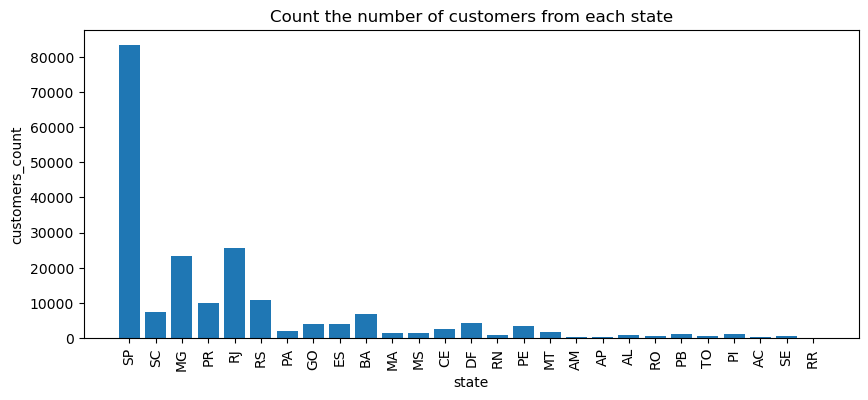

In [158]:
query = """select distinct customer_state,count(customer_id) from customers group by customer_state """
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["state","coustomer_count"])
df

plt.figure(figsize = (10,4))
plt.bar(df["state"],df["coustomer_count"])
plt.xticks(rotation = 90)
plt.title("Count the number of customers from each state")
plt.xlabel("state")
plt.ylabel("customers_count")
plt.show()

# Calculate the number of orders per month in 2018.

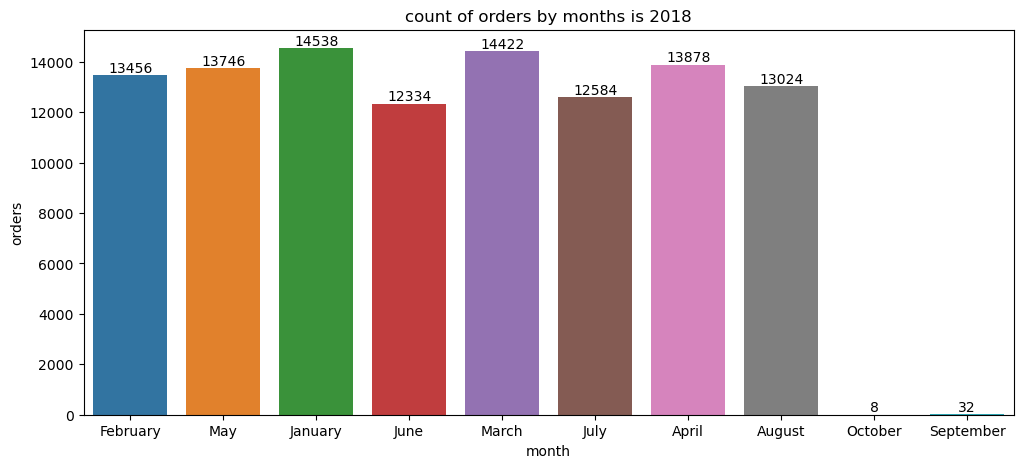

In [150]:
query = """select monthname(order_purchase_timestamp) month ,count(order_id) from orders where year(order_purchase_timestamp) = 2018 group by month"""
cur.execute(query)

data = cur.fetchall()
o = {"January","February","March","April","May","June","July","August","September","October"}


plt.figure(figsize=(12,5))
df = pd.DataFrame(data,columns = ["month","orders"])
ax = sns.barplot(x = df["month"],y = df["orders"],data = df , order = o)
ax.bar_label(ax.containers[0])
plt.title("count of orders by months is 2018")
plt.show()


# Find the average number of products per order, grouped by customer city.

In [14]:
query = """with count_per_order as 
(select orders.order_id,orders.customer_id ,count(order_items.order_id) as oc
from orders join order_items on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc;
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["customer_city","average_orders"])
df
df.head(10)

,customer_city,average_orders
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


# Calculate the percentage of total revenue contributed by each product category.

In [5]:
query = """ select upper( products.product_category) as category ,round((sum(payments.payment_value)/(select sum(payment_value) from payments)) * 100,2) as sales_percentaeg 
from order_items join products 
on order_items.product_id = products.product_id 
join payments 
on  payments.order_id = order_items.order_id 
group by category order by sales_percentaeg desc
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["category","sales_percentaeg"])
df
df.head(10)

,category,sales_percentaeg
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
5,SPORT LEISURE,34.78
6,HOUSEWARES,27.35
7,AUTOMOTIVE,21.30
8,GARDEN TOOLS,20.95
9,COOL STUFF,19.48


# Identify the correlation between product price and the number of times a product has been purchased.

In [26]:
query = """ select products.product_category as category , count(order_items.product_id) , round(avg(order_items.price),2) as avg_price
from products join order_items 
on products.product_id = order_items.product_id
group by category
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["category","order_count","avg_price"])
df
df.head(10)

arr1 = df["order_count"]
arr2 = df["avg_price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is",a[0][1])


the correlation between price and number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [29]:
query = """ select * ,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["seller_id","revenue","rank"])
df
df.head(10)

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,2.028668e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1.232888e+06,2
2,4a3ca9315b744ce9f8e9374361493884,1.204981e+06,3
3,1f50f920176fa81dab994f9023523100,1.161014e+06,4
4,53243585a1d6dc2643021fd1853d8905,1.139612e+06,5
5,da8622b14eb17ae2831f4ac5b9dab84a,1.088877e+06,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,1.056664e+06,7
7,955fee9216a65b617aa5c0531780ce60,9.452892e+05,8
8,fa1c13f2614d7b5c4749cbc52fecda94,8.260529e+05,9
9,7e93a43ef30c4f03f38b393420bc753a,7.405368e+05,10


# Calculate the moving average of order values for each customer over their order history.

In [8]:
query = """ select customer_id,order_purchase_timestamp,payment,
avg(payment)over (partition by orders.customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from orders join payments
on orders.order_id = payments.order_id) as a
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["customer_id","order_timestamp","payment","moving_avg"])
df
df.head(10)

,customer_id,order_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
5,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
6,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
7,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
8,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
9,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998


# Calculate the cumulative sales per month for each year.

In [4]:
query = """select years,months,payment,sum(payment)over
(order by years , months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months, round(sum(payments.payment_value),2)as payment
from orders join payments on orders.order_id = payments.payment_value
group by years , months order by years , months) as a
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["years","months","sales","cumulative_sales"])
df
df.head(10)

,years,months,sales,cumulative_sales
0,2016,9,0.0,0.0
1,2016,10,360072.0,360072.0
2,2016,12,0.0,360072.0
3,2017,1,607128.0,967200.0
4,2017,2,1416372.0,2383572.0
5,2017,3,2304184.0,4687756.0
6,2017,4,2056356.0,6744112.0
7,2017,5,3180624.0,9924736.0
8,2017,6,2765740.0,12690476.0
9,2017,7,3395988.0,16086464.0


# Calculate the year-over-year growth rate of total sales

In [14]:
query = 
""" select years,(payment-lag(payment,1) over (order by years)/lag(payment,1) over (order by years))*100 as yoy
from
(select year(orders.order_purchase_timestamp) as years, round(sum(payments.payment_value),2)as payment
from orders join payments on orders.order_id = payments.payment_value
group by years  order by years) as a
"""
# query = """ with a as (select year(orders.order_purchase_timestamp) as years, round(sum(payments.payment_value),2)as payment
# from orders join payments on orders.order_id = payments.payment_value
# group by years  order by years ) 
# select years,(payment-lag(payment) over (order by years)/lag(payment,1) over (order by years))*100  as yoy  from a
# """
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["years","yoy %"])
df
df.head(10)

,years,yoy %
0,2016,NaN
1,2017,3.849974e+09
2,2018,4.601518e+09


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [17]:
query = """ with a as (select customers.customer_id,min(orders.order_purchase_timestamp) as first_order from customers join orders
on customers.customer_id = orders.customer_id group by customer_id) ,
b as (select a.customer_id , count(distinct orders.order_purchase_timestamp) from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order 
and orders.order_purchase_timestamp <
adddate(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""

cur.execute(query)

data = cur.fetchall()


print(data ," since of our customer are repeated thats why our value is null")



[(None,)]  since of our customer are repeated thats why our value is null


# Identify the top 3 customers who spent the most money in each year

In [18]:
query = """select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,orders.customer_id,sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
from orders join payments
on  payments.order_id = orders.order_id 
group by year(orders.order_purchase_timestamp),orders.customer_id ) as a where d_rank <=3 
"""
cur.execute(query)

data = cur.fetchall()


df = pd.DataFrame(data,columns = ["years","customer_id","payment","rank"])
df


,years,customer_id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,5694.200195,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,5602.959961,2
2,2016,4a06381959b6670756de02e07b83815f,4911.120117,3
3,2017,1617b1357756262bfa56ab541c47bc16,54656.320312,1
4,2017,c6e2731c5b391845f6800c97401a43a9,27717.240234,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,26906.640625,3
6,2018,ec5b2ba62e574342386871631fafd3fc,29099.519531,1
7,2018,f48d464a0baaea338cb25f816991ab1f,27688.839844,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,19237.759766,3
